A3C (Asynchronous Advantage Actor Critic) implementation with Tensorflow. 
This is a multi-threaded continuous version with N step targets 
(use maximum terms possible). The code is tested with Pendulum-v0 (which has a continuous action space) on Colab.

#Use tensorflow version 1.15.2

In [1]:
!pip install tensorflow==1.15.2

     |████████████████████████████████| 110.5MB 47kB/s 
     |████████████████████████████████| 512kB 43.5MB/s 
     |████████████████████████████████| 3.8MB 48.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a339b9221095770664ea9a2728d8d95202766e6c0ebcaaacdd07eff43fa6cdd5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installatio

#Imports

In [0]:
import threading
import multiprocessing
import time

import numpy as np
import matplotlib.pyplot as plt

import gym
import tensorflow as tf

#Global variables & hyperparameters

In [3]:
game = 'Pendulum-v0'
#game = 'MountainCarContinuous-v0'
env = gym.make(game).unwrapped

num_obvs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
action_bound = [env.action_space.low, env.action_space.high]

net_scope = 'global'
max_episode = 2000 # total samples collected # 80e6
max_episode_step = 200 # steps per episode
update_rate = 10 # t steps, nets synced rate
#delay_rate = 50 #4000 # t steps, local gradients storage reset rate

#!cat /proc/cpuinfo
#print("CPU:", multiprocessing.cpu_count())
#num_workers = multiprocessing.cpu_count() 
num_workers = 4 #16

GAMMA = 0.9 #0.99
ENTROPY_BETA = 0.01 #0.01
actor_alpha = 0.0001 #7e-4
critic_alpha = 0.001 #7e-4   
actor_hidden = 80 #200
critic_hidden = 50 #200
cell_size = 64 #128
N_step = 3 #15

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#Class that computes running stats

In [0]:
class RunningStats(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    # https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        new_mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)
        self.count = batch_count + self.count

#The actor-critic tensorflow graph

In [0]:
class ACNet(object):
    def __init__(self, scope, globalAC=None):           
        if scope == net_scope: # global
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, num_obvs], 'S')
                # create global net
                self.actor_params, self.critic_params = self._create_net(scope)[-2:] # only require params
                
        else: # local
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, num_obvs], 'S')
                self.a = tf.placeholder(tf.float32, [None, num_actions], 'A') # continous action, use float32 instead of int32
                self.critic_target = tf.placeholder(tf.float32, [None, 1], 'critic_target')
                self.baselined_returns = tf.placeholder(tf.float32, [None, 1], 'baselined_returns') # for calculating advantage 
                mean, sigma, self.V, self.actor_params, self.critic_params = self._create_net(scope) # create local net
                    
                with tf.name_scope('select_action'):
                    #mean = mean * action_bound[1]                   
                    mean = mean * ( action_bound[1] - action_bound[0] ) / 2
                    sigma += 1e-4
                    normal_dist = tf.distributions.Normal(mean, sigma)                     
                    self.choose_a = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=[0, 1]), action_bound[0], action_bound[1])                  
                    
                TD_err = tf.subtract(self.critic_target, self.V, name='TD_err')
                with tf.name_scope('actor_loss'):
                    log_prob = normal_dist.log_prob(self.a)
                    #actor_component = log_prob * tf.stop_gradient(TD_err)
                    actor_component = log_prob * tf.stop_gradient(self.baselined_returns)
                    entropy = -tf.reduce_mean(normal_dist.entropy()) # Compute the differential entropy of the multivariate normal.                   
                    self.actor_loss = -tf.reduce_mean( ENTROPY_BETA * entropy + actor_component)
                with tf.name_scope('critic_loss'):
                    self.critic_loss = tf.reduce_mean(tf.square(TD_err))                                      
                                        
                with tf.name_scope('local_grad'):
                    self.actor_grads = tf.gradients(self.actor_loss, self.actor_params)
                    self.critic_grads = tf.gradients(self.critic_loss, self.critic_params)
                # accumulated gradients for local actor    
                with tf.name_scope('local_actor_grad'):                   
                    self.actor_zero_op, self.actor_accumu_op, self.actor_apply_op, actor_accum = self.accumu_grad(OPT_A, self.actor_loss, scope=scope + '/actor')
                # accumulated gradients for local actor    
                with tf.name_scope('local_critic_grad'):
                    self.critic_zero_op, self.critic_accumu_op, self.critic_apply_op, critic_accum = self.accumu_grad(OPT_C, self.critic_loss, scope=scope + '/critic')

            with tf.name_scope('params'): # push/pull from local/worker perspective
                with tf.name_scope('push_to_global'):
                    self.push_actor_params = OPT_A.apply_gradients(zip(actor_accum, globalAC.actor_params))
                    self.push_critic_params = OPT_C.apply_gradients(zip(critic_accum, globalAC.critic_params))
                    #self.push_actor_params = OPT_A.apply_gradients(zip(self.actor_grads, globalAC.actor_params))
                    #self.push_critic_params = OPT_C.apply_gradients(zip(self.critic_grads, globalAC.critic_params))
                with tf.name_scope('pull_fr_global'):
                    self.pull_actor_params = [local_params.assign(global_params) for local_params, global_params in zip(self.actor_params, globalAC.actor_params)]
                    self.pull_critic_params = [local_params.assign(global_params) for local_params, global_params in zip(self.critic_params, globalAC.critic_params)]                    

    def _lstm(self, Inputs, cell_size):
            s = tf.expand_dims(Inputs, axis=1, name='time_major')  # [time_step, feature] => [time_step, batch, feature]
            lstm_cell = tf.nn.rnn_cell.LSTMCell(cell_size)
            self.init_state = lstm_cell.zero_state(batch_size=1, dtype=tf.float32)
            # time_major means [time_step, batch, feature] while batch major means [batch, time_step, feature]
            outputs, self.final_state = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=s, initial_state=self.init_state, time_major=True)
            lstm_out = tf.reshape(outputs, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation          
            return lstm_out
        
    def _create_net(self, scope):
        w_init = tf.glorot_uniform_initializer()
        #w_init = tf.random_normal_initializer(0., .1)
        with tf.variable_scope('actor'):                        
            hidden = tf.layers.dense(self.s, actor_hidden, tf.nn.relu6, kernel_initializer=w_init, name='hidden')            
            #lstm_out = self._lstm(hidden, cell_size)
            # tanh range = [-1,1]
            mean = tf.layers.dense(hidden, num_actions, tf.nn.tanh, kernel_initializer=w_init, name='mean')
            # softplus range = {0,inf}
            sigma = tf.layers.dense(hidden, num_actions, tf.nn.softplus, kernel_initializer=w_init, name='sigma')
        with tf.variable_scope('critic'):
            hidden = tf.layers.dense(self.s, critic_hidden, tf.nn.relu6, kernel_initializer=w_init, name='hidden')
            lstm_out = self._lstm(hidden, cell_size)
            V = tf.layers.dense(lstm_out, 1, kernel_initializer=w_init, name='V')  
        actor_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        critic_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
        return mean, sigma, V, actor_params, critic_params
      
    def accumu_grad(self, OPT, loss, scope):
        # retrieve trainable variables in scope of graph
        #tvs = tf.trainable_variables(scope=scope + '/actor')
        tvs = tf.trainable_variables(scope=scope)
        # ceate a list of variables with the same shape as the trainable
        accumu = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in tvs]
        zero_op = [tv.assign(tf.zeros_like(tv)) for tv in accumu] # initialized with 0s
        gvs = OPT.compute_gradients(loss, tvs) # obtain list of gradients & variables
        #gvs = [(tf.where( tf.is_nan(grad), tf.zeros_like(grad), grad ), var) for grad, var in gvs_]
        # adds to each element from the list you initialized earlier with zeros its gradient 
        # accumu and gvs are in same shape, index 0 is grads, index 1 is vars
        accumu_op = [accumu[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
        # apply grads
        apply_op = OPT.apply_gradients([(accumu[i], gv[1]) for i, gv in enumerate(gvs)])
        return zero_op, accumu_op, apply_op, accumu

    def push_global_actor(self, feed_dict):  
        SESS.run([self.push_actor_params], feed_dict)  

    def push_global_critic(self, feed_dict):  
        SESS.run([self.push_critic_params], feed_dict)         
        
    def pull_global(self):  
        SESS.run([self.pull_actor_params, self.pull_critic_params])

    def choose_action(self, s):  # run by a local
        s = s[None, :]
        return SESS.run(self.choose_a, {self.s: s})
    
    def init_grad_storage_actor(self):
        SESS.run(self.actor_zero_op)
        
    def accumu_grad_actor(self, feed_dict):
        SESS.run([self.actor_accumu_op], feed_dict)          
    
    def apply_accumu_grad_actor(self, feed_dict):
        SESS.run([self.actor_apply_op], feed_dict)   
        
    def init_grad_storage_critic(self):
        SESS.run(self.critic_zero_op)
        
    def accumu_grad_critic(self, feed_dict):
        SESS.run([self.critic_accumu_op], feed_dict)          
    
    def apply_accumu_grad_critic(self, feed_dict):
        SESS.run([self.critic_apply_op], feed_dict)

#Worker class

In [0]:
class Worker(object): # local only
    def __init__(self, name, globalAC):
        self.env = gym.make(game).unwrapped
        self.name = name
        self.AC = ACNet(name, globalAC)
        
    def work(self):
        global GLOBAL_RUNNING_R, GLOBAL_EP, running_stats
        t = 1 # local t, init only once
        buffer_s, buffer_a, buffer_r = [], [], []
        
        while not COORD.should_stop() and GLOBAL_EP < max_episode:
            s = self.env.reset() # get start state
            ep_r = 0 # reward per episode
            for ep_t in range(max_episode_step):
                a = self.AC.choose_action(s)                
                s_, r, done, info = self.env.step(a)                                
                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                
                buffer_r.append(r) 
                
                #if done == False:
                done = True if ep_t == max_episode_step - 1 else False
                
                if done or t % update_rate == 0:                            
                    # R for computing discounted reward
                    if done:
                        R = 0   
                    else:
                        R = SESS.run(self.AC.V, {self.AC.s: s_[None, :]})[0, 0] # takes in just one s, not a batch.
                        
                    #running_stats.update(np.array(buffer_r))
                    #buffer_r = np.clip(np.array(buffer_r) / running_stats.std, -10, 10)
                    
                    critic_target = self.discount_rewards(buffer_r, GAMMA, R)            
                                        
                    buffer_s, buffer_a, critic_target = np.vstack(buffer_s), np.array(buffer_a), np.vstack(critic_target)
                    feed_dict = {self.AC.s: buffer_s, self.AC.critic_target: critic_target}  
                    self.AC.accumu_grad_critic(feed_dict) # accumulating gradients for local critic   
                    self.AC.apply_accumu_grad_critic(feed_dict) # apply gradients to local critic
                    
                    baseline = SESS.run(self.AC.V, {self.AC.s: buffer_s}) # value function                        
                    epr = np.vstack(buffer_r).astype(np.float32)
                    # Q values
                    n_step_targets = self.n_step_targets_max(epr, baseline, R, GAMMA, N_step)
                    # advantage
                    baselined_returns = n_step_targets - baseline

                    #feed_dict = {self.AC.s: buffer_s, self.AC.a: buffer_a, self.AC.critic_target: critic_target}
                    feed_dict = {self.AC.s: buffer_s, self.AC.a: buffer_a, self.AC.critic_target: critic_target, self.AC.baselined_returns: baselined_returns}
                    self.AC.accumu_grad_actor(feed_dict) # accumulating gradients for local actor        
                    
                    # update to global
                    self.AC.push_global_actor(feed_dict)                
                    self.AC.push_global_critic(feed_dict)   
                    self.AC.pull_global() # sync
                    buffer_s, buffer_a, buffer_r = [], [], []

                    self.AC.init_grad_storage_actor()   
                    self.AC.init_grad_storage_critic()      
                    
                    #if t % delay_rate == 0: # delay clearing of local gradients storage to reduce noise
                        # update to global
                        #self.AC.push_global_actor(feed_dict)                
                        #self.AC.push_global_critic(feed_dict)   
                        #self.AC.pull_global() # sync
                        # reinitialize storage for accumulated gradients.
                        #self.AC.init_grad_storage_actor()   
                        #self.AC.init_grad_storage_critic()      
                s = s_
                t += 1  
                if done:
                    if len(GLOBAL_RUNNING_R) == 0:  # record running episode reward
                        GLOBAL_RUNNING_R.append(ep_r)
                    else:
                        GLOBAL_RUNNING_R.append(0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * ep_r)
                    GLOBAL_EP += 1
                    break                                                        
    
    def discount_rewards(self, r, gamma, running_add):
      """Take 1D float array of rewards and compute discounted reward """
      discounted_r = np.zeros_like(r)
      #running_add = 0
      for t in reversed(range(len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
      return discounted_r    
    
    # As n increase, variance increase.
    # Create a function that returns an array of n-step targets, one for each timestep:
    # target[t] = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... + \gamma^n V(s_{t+n})
    # Where r_t is given by episode reward (epr) and V(s_n) is given by the baselines.    
    def n_step_targets_max(self, epr, baselines, v_s_, gamma, N):
      targets = np.zeros_like(epr)    
      if N > epr.size:
        N = epr.size
      for t in range(epr.size):    
        for n in range(N):
          if t+n == epr.size:
            targets[t] += (gamma**n) * v_s_  # use max steps available
            break
          if n == N-1: # last term
            targets[t] += (gamma**n) * baselines[t+n]
          else:
            targets[t] += (gamma**n) * epr[t+n] 
      return targets  

#Rollout & train

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `t

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


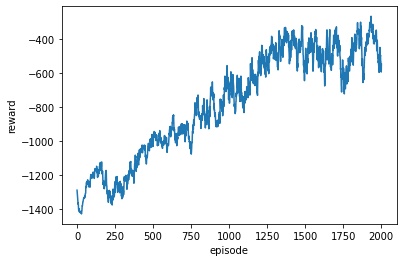

--- 546.5065996646881 seconds ---


In [7]:
start_time = time.time()
    
SESS = tf.Session()   
with tf.device("/cpu:0"):
    OPT_A = tf.train.RMSPropOptimizer(actor_alpha, name='OPT_A')
    OPT_C = tf.train.RMSPropOptimizer(critic_alpha, name='OPT_C')
    GLOBAL_AC = ACNet(net_scope, globalAC=None) # only need its params
    workers = []
    for i in range(num_workers): # Create worker
        i_name = 'W_%i' % i # worker name
        workers.append(Worker(i_name, GLOBAL_AC))  
        
    GLOBAL_RUNNING_R = [] # for display
    GLOBAL_EP = 0 # total number of steps of all episodes
    running_stats = RunningStats()
      
    COORD = tf.train.Coordinator()
    SESS.run(tf.global_variables_initializer())
            
    worker_threads = []
    for worker in workers:
        job = lambda: worker.work()
        t = threading.Thread(target=job)
        t.start()
        worker_threads.append(t)
    COORD.join(worker_threads)
    
    # display
    plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.show()    
    
print("--- %s seconds ---" % (time.time() - start_time))    